# Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dask_data
#Dask data frames used to help in in-memory large computing on a single machine

#visualization specific imports 
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot, download_plotlyjs

import sklearn
import matplotlib.dates as mdates

In [2]:
matplotlib.style.use('ggplot')

#A parse date variable to pass in the read_csv function later to take into account the date format 
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

# Sampling and Loading the data

In [3]:
''' Specifying a sample of the original training data 
    Training data size == 5.87 gigabytes 
    Number of records === 40428966 (excess of 40 million records)
    
    Using random sampling to select a sample of 1 million records 
'''

import random
n = 40428966  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

#Tracking the indices of rows to be skipped at random in the next stage i.e the LOADING stage 

In [4]:
''' LOADING stage 
    Reading the sampled train data
    Size : 1 million records
'''

train_data = pd.read_csv('train.csv', parse_dates = ['hour'], date_parser = parse_date,
                        skiprows = skip_values )

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
id                  1000001 non-null uint64
click               1000001 non-null int64
hour                1000001 non-null datetime64[ns]
C1                  1000001 non-null int64
banner_pos          1000001 non-null int64
site_id             1000001 non-null object
site_domain         1000001 non-null object
site_category       1000001 non-null object
app_id              1000001 non-null object
app_domain          1000001 non-null object
app_category        1000001 non-null object
device_id           1000001 non-null object
device_ip           1000001 non-null object
device_model        1000001 non-null object
device_type         1000001 non-null int64
device_conn_type    1000001 non-null int64
C14                 1000001 non-null int64
C15                 1000001 non-null int64
C16                 1000001 non-null int64
C17                 1000001 non-null int64
C18     

In [6]:
#train_data

# Memory Optimization

In [7]:
'''
Memory optimization at this point ~~ 183 megabytes 

Optimization technique ::: Alter data types from int64 to int16 to reduce block memory usage

Then RELOADING the data 
'''
data_types = {
    'id': np.str,
    'click': np.uint16,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16
}

train_data = pd.read_csv('train.csv', parse_dates = ['hour'],
                        date_parser = parse_date, skiprows = skip_values , 
                        dtype = data_types )

In [8]:
train_data.info() 


## Memory consumption reduced to 108.7 + MB

'''
% reduction in memory usage = 40% 
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
id                  1000001 non-null object
click               1000001 non-null uint16
hour                1000001 non-null datetime64[ns]
C1                  1000001 non-null uint16
banner_pos          1000001 non-null uint16
site_id             1000001 non-null object
site_domain         1000001 non-null object
site_category       1000001 non-null object
app_id              1000001 non-null object
app_domain          1000001 non-null object
app_category        1000001 non-null object
device_id           1000001 non-null object
device_ip           1000001 non-null object
device_model        1000001 non-null object
device_type         1000001 non-null uint16
device_conn_type    1000001 non-null uint16
C14                 1000001 non-null uint16
C15                 1000001 non-null uint16
C16                 1000001 non-null uint16
C17                 1000001 non-null uint16

'\n% reduction in memory usage = 40% \n'

# Exploratory Data Analysis

In [9]:
""""File descriptions
train - Training set. 10 days of click-through data, ordered chronologically. Non-clicks and clicks are subsampled according to different strategies.
test - Test set. 1 day of ads to for testing your model predictions. 
sampleSubmission.csv - Sample submission file in the correct format, corresponds to the All-0.5 Benchmark.
Data fields
id: ad identifier
click: 0/1 for non-click/click
hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
C1 -- anonymized categorical variable
banner_pos
site_id
site_domain
site_category
app_id
app_domain
app_category
device_id
device_ip
device_model
device_type
device_conn_type
C14-C21 -- anonymized categorical variables"""

'''
24 features encompassing site attributes, application features, device attributes 

Target features - click 
C14 - C21 - Anonymized categorical variables 

Features kept anonymous via. md5 hashing encrypton : 
  
Site features - Site_id, Site_domain, Site_category
App features - app_id, app_domain 
Device features - device_type, device_conn_type 

'''

'\n24 features encompassing site attributes, application features, device attributes \n\nTarget features - click \nC14 - C21 - Anonymized categorical variables \n\nFeatures kept anonymous via. md5 hashing encrypton : \n  \nSite features - Site_id, Site_domain, Site_category\nApp features - app_id, app_domain \nDevice features - device_type, device_conn_type \n\n'

In [10]:
train_data.head()
# train_data.to_csv('train_subset.csv', index=False)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000371904215119486,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,34548,79
1,10005541670676403131,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20984,320,50,2371,0,551,34681,46
2,10011658782619041235,1,2014-10-21,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,65535,79
3,10017640116993553715,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15707,320,50,1722,0,35,34548,79
4,10024365483589149864,0,2014-10-21,1002,0,ec1aa5a1,42fb0c49,50e219e0,ecad2386,7801e8d9,...,0,0,20170,300,50,2312,0,167,65535,16


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
id                  1000001 non-null object
click               1000001 non-null uint16
hour                1000001 non-null datetime64[ns]
C1                  1000001 non-null uint16
banner_pos          1000001 non-null uint16
site_id             1000001 non-null object
site_domain         1000001 non-null object
site_category       1000001 non-null object
app_id              1000001 non-null object
app_domain          1000001 non-null object
app_category        1000001 non-null object
device_id           1000001 non-null object
device_ip           1000001 non-null object
device_model        1000001 non-null object
device_type         1000001 non-null uint16
device_conn_type    1000001 non-null uint16
C14                 1000001 non-null uint16
C15                 1000001 non-null uint16
C16                 1000001 non-null uint16
C17                 1000001 non-null uint16

In [12]:
train_data_clicks = train_data[train_data['click']==1]

In [13]:
train_data_clicks

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
2,10011658782619041235,1,2014-10-21 00:00:00,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,65535,79
8,10048447583457364145,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15703,320,50,1722,0,35,65535,79
18,10100912820372977887,1,2014-10-21 00:00:00,1005,0,7697ed3e,c1aa3c04,f028772b,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,65535,157
24,10127411676339727448,1,2014-10-21 00:00:00,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17654,300,250,1994,2,39,34548,33
27,10152741405525596559,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15704,320,50,1722,0,35,34548,79
30,10177666544903301910,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15702,320,50,1722,0,35,34548,79
31,10182020780809819700,1,2014-10-21 00:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,65535,79
35,10203905128764170651,1,2014-10-21 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,...,1,0,20634,320,50,2374,3,39,65535,23
47,10253184020497513532,1,2014-10-21 00:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,0e1429fd,d9b5648e,...,1,0,20980,320,50,2371,0,551,65535,46
52,10271587644058454574,1,2014-10-21 00:00:00,1002,0,85f751fd,c4e18dd6,50e219e0,a37bf1e4,7801e8d9,...,0,0,21678,320,50,2495,2,167,65535,23


0    0.829894
1    0.170106
Name: click, dtype: float64

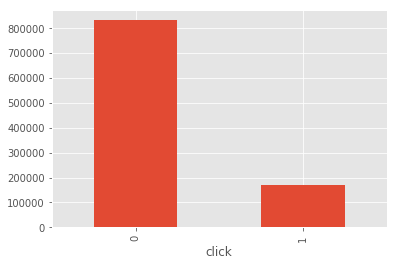

In [14]:
%matplotlib inline

train_data.groupby('click').size().plot(kind = 'bar')
rows = train_data.shape[0]

click_through_rate = train_data['click'].value_counts()/rows 

click_through_rate

### Click through rate on a set of 1 million records of click stream data sampled at random from the population of 40 million records is 16.9 ~ 17%. CTR effectively = 17% 

# Feature Engineering

### Studying the relationships between different features and the target variable i.e 'Click'. 
### Manipulating data in the process, introducing new metrics

In [15]:
'''
Metric 1. HOUR 
'''
train_data.hour.describe() 

#The top is the most common value. The freq is the most common value’s frequency.

count                 1000001
unique                    240
top       2014-10-22 09:00:00
freq                    11113
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

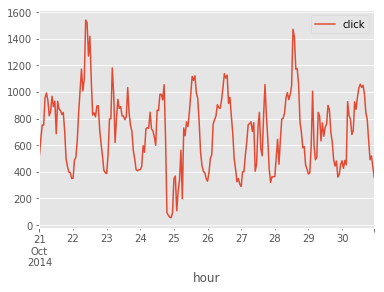

In [16]:
df_click = train_data[train_data['click']==1]
temp_click = df_click.groupby('hour').agg({'click' : 'count'})
temp_click.plot()

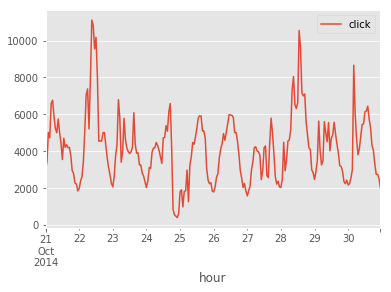

In [17]:
df_impressions = train_data.groupby('hour').agg({'click':'count'})
df_impressions
df_impressions.plot()

#### MAXIMUM number of clicks around 12-1 P.M ~ 1600

In [18]:
''' HOUR as a metric is difficult to read because it is a time stamp 
    Introducing new metrics: 
     1. hour_in_day - Better KPI to assess the impressions v/s clicks behavior w.r.t hour in day
     2. weekday -- To study user behavior w.r.t clicks on each day 
     3. Day_name -- To extract the day name from the HOUR feature for a better understanding 
'''

train_data['hour_in_day'] = train_data['hour'].apply(lambda val : val.hour)
train_data_clicks['hour_in_day'] = train_data_clicks['hour'].apply(lambda val : val.hour)

train_data['weekday'] = train_data['hour'].apply(lambda val: val.dayofweek)
train_data_clicks['weekday'] = train_data_clicks['hour'].apply(lambda val: val.dayofweek)

train_data['day_name'] = train_data['hour'].apply(lambda x: x.strftime('%A'))
train_data_clicks['day_name'] = train_data_clicks['hour'].apply(lambda x: x.strftime('%A'))

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [19]:
train_data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_in_day',
       'weekday', 'day_name'],
      dtype='object')

In [20]:
train_data['day_name'].unique()

array(['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'], dtype=object)

In [21]:
train_data['weekday'].unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

## Time Analysis

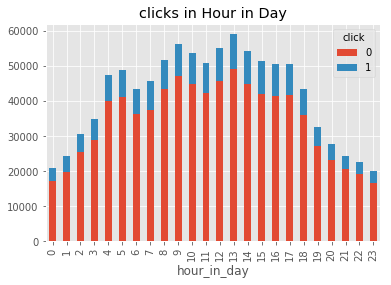

In [22]:
#train_data['hour_in_day'].nunique() ~ 0 TO 23 
train_data.groupby(['hour_in_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="clicks in Hour in Day")

In [23]:
train_data[['hour_in_day','click']].groupby(['hour_in_day']).count().sort_values('click',ascending=False)

,click
hour_in_day,
13,59103
9,56196
12,55208
14,54371
10,53557
8,51651
15,51398
11,50817
17,50478


In [24]:
train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().sort_values('click',ascending=False)

,click
hour_in_day,
13,10021
14,9624
12,9451
15,9360
9,9064
16,9054
17,8893
10,8622
11,8561


In [25]:
# train_data[['hour','click']].groupby(['hour']).count().sort_values('click',ascending=False)

In [26]:
# train_data_clicks[['hour','click']].groupby(['hour']).count().sort_values('click',ascending=False)

In [27]:
hour_df = pd.DataFrame() 
hour_df['hr'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['hour_in_day']
hour_df['pos_clicks'] = train_data_clicks[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
hour_df['impressions_total'] = train_data[['hour_in_day','click']].groupby(['hour_in_day']).count().reset_index().sort_values('click',ascending=False)['click']
hour_df['click_through_rate'] = 100*hour_df['pos_clicks']/hour_df['impressions_total']
#hour_df.sort_values(ascending = False, by = 'impressions_total')
hour_df.sort_values(ascending = False, by = 'click_through_rate')

,hr,pos_clicks,impressions_total,click_through_rate
1,1,4585,24264,18.896307
0,0,3874,20903,18.533225
15,15,9360,51398,18.210825
7,7,8254,45637,18.086202
16,16,9054,50456,17.944348
14,14,9624,54371,17.700612
17,17,8893,50478,17.617576
2,2,5387,30674,17.562105
23,23,3502,20074,17.445452
12,12,9451,55208,17.118896


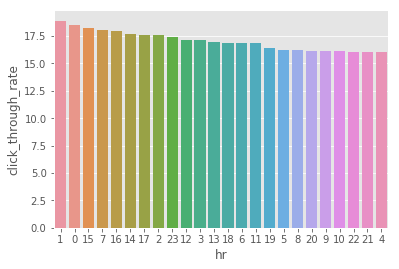

In [28]:
list_of_hours = hour_df.sort_values(by='click_through_rate',ascending=False)['hr'].tolist()
import seaborn as sns
sns.barplot(y='click_through_rate',x='hr',data=hour_df,order=list_of_hours)

## Day of Week Analysis

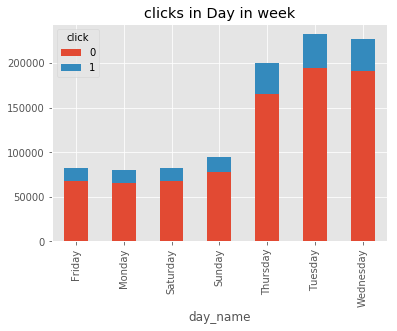

In [29]:
train_data.groupby(['day_name', 'click']).size().unstack().plot(kind='bar', stacked=True, title="clicks in Day in week")

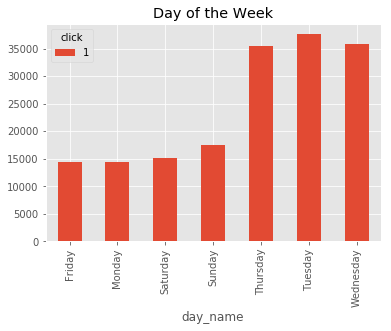

In [30]:
train_data_clicks.groupby(['day_name','click']).size().unstack().plot(kind='bar', stacked=True, title="Day of the Week")

In [31]:
train_data_clicks[['day_name','click']].groupby(['day_name']).count().sort_values('click',ascending=False)

,click
day_name,
Tuesday,37597
Wednesday,35772
Thursday,35438
Sunday,17400
Saturday,15107
Friday,14436
Monday,14356


### Most clicks on Tuesday, then wednesday followed by Thursday

In [32]:
day_df = pd.DataFrame()
day_df['day'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['day_name']
day_df['pos_clicks'] = train_data_clicks[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['click']
day_df['total_impressions'] = train_data[['day_name','click']].groupby(['day_name']).count().reset_index().sort_values('click',ascending=False)['click']
day_df['click_pct'] = 100*day_df['pos_clicks']/day_df['total_impressions']
day_df.sort_values(ascending = False, by = 'click_pct')

,day,pos_clicks,total_impressions,click_pct
3,Sunday,17400,95092,18.298069
2,Saturday,15107,82730,18.260607
1,Monday,14356,79618,18.031098
4,Thursday,35438,200493,17.675430
0,Friday,14436,82531,17.491609
5,Tuesday,37597,232429,16.175692
6,Wednesday,35772,227108,15.751096


### Sunday has the highest value of click through rate 

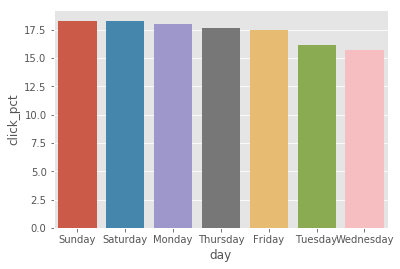

In [33]:
list_of_days = day_df.sort_values(by='click_pct',ascending=False)['day'].tolist()
sns.barplot(y='click_pct',x='day',data=day_df,order=list_of_days)

## Banner Position Analysis

In [34]:
train_data['banner_pos'].unique()

array([0, 1, 5, 2, 4, 7, 3], dtype=uint64)

#### The 7 banner positions (represented as integers) represent ad placing in a 2D webpage  

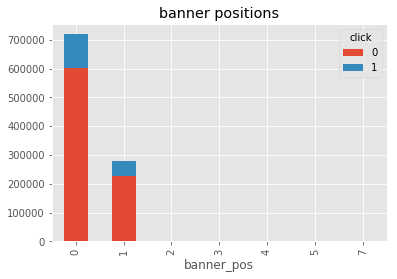

In [35]:
banner_temp =train_data[['banner_pos','click']].groupby(['banner_pos','click'])
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

#### Positions 0 and 1 ~ the most prominent banner positions garnering most impressions 

In [36]:
train_data[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,718939
1,279288
7,1078
2,331
4,179
5,135
3,51


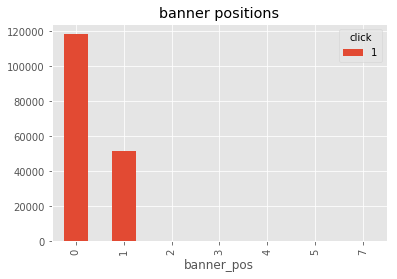

In [37]:
banner_temp =train_data_clicks[['banner_pos','click']].groupby(['banner_pos','click'])
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

In [38]:
train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,118263
1,51414
7,330
2,49
4,34
3,9
5,7


### BANNER POSITIONS 0 and 1 are generating most impressions and clicks both

In [39]:
banner_df = pd.DataFrame()
banner_df['position'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']
banner_df['pos_clicks'] = train_data_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['total_impressions'] = train_data[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']
banner_df.sort_values(ascending=False,by='click_pct')

,position,pos_clicks,total_impressions,click_pct
6,7,330,1078,30.612245
4,4,34,179,18.994413
1,1,51414,279288,18.408954
3,3,9,51,17.647059
0,0,118263,718939,16.449657
2,2,49,331,14.803625
5,5,7,135,5.185185


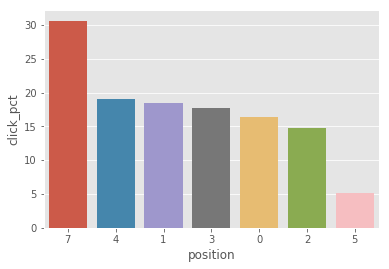

In [40]:
list_of_banners = banner_df.sort_values(by='click_pct',ascending=False)['position'].tolist()
sns.barplot(y='click_pct',x='position',data=banner_df,order=list_of_banners)

#### Banner position 7 seems to be a nice choice for placing advertisements. As per click through rate. 

## Device Related Metric Analysis

In [41]:
train_data['device_conn_type'].value_counts()

0    863155
2     81504
3     54266
5      1076
Name: device_conn_type, dtype: int64

In [42]:
train_data['device_id'].value_counts()

a99f214a    825285
0f7c61dc       548
c357dbff       462
936e92fb       343
afeffc18       222
b09da1c4       115
987552d1       103
28dc8687        87
d857ffbb        87
cef4c8cc        86
02da5312        73
3cdb4052        64
03559b29        61
abab24a7        43
096a6f32        40
9af87478        35
d2e4c0ab        32
1de30ee7        30
468ee576        29
f1d9c744        29
bea61865        28
f58a1c3b        28
0a04637d        27
41cfe06b        27
1fcc7653        26
4e9e9550        26
2c112522        25
cafca232        25
f0b5276b        25
7d53058f        25
             ...  
df628c94         1
e0520b1c         1
1c87aa75         1
64ecbc20         1
32491e5c         1
ec6d7ee0         1
86f092ac         1
5b4e0559         1
6ef0cfc2         1
70af7a14         1
ba65acce         1
614620ce         1
75607b43         1
9b4bf572         1
053d2fd4         1
c8cf39a3         1
00825512         1
ced3965e         1
917a2237         1
541ac53e         1
86058234         1
99b4fcc6    

In [43]:
train_data['device_ip'].value_counts()

6b9769f2    5096
431b3174    3299
2f323f36    2318
af9205f9    2175
af62faf4    2155
6394f6f6    2078
009a7861    2077
930ec31d    2077
285aa37d    2055
d90a7774    1989
c6563308    1814
75bb1b58    1777
a8536f3a    1750
488a9a3e    1743
ddd2926e    1742
57cd4006    1733
1cf29716    1729
ceffea69    1728
0489ce3f    1677
8a014cbb    1647
9b1fe278    1636
7ed30f6c     957
07875ea4     909
b0070d9a     860
693bff3e     834
bca8f26d     828
ac77b71a     820
95b2935e     763
e54c1344     742
ff1c4f79     727
            ... 
f7f20fa6       1
a7a2f988       1
5c96300a       1
05f91639       1
dc02e9f3       1
c207fa5b       1
d898c644       1
41e96008       1
27507e6f       1
55143262       1
8e1c55d4       1
c2329115       1
693dad86       1
4fa7b4d0       1
527eee84       1
bcefd1e4       1
8bade4a4       1
7d4b753b       1
5589c3f0       1
fb07c644       1
305d085d       1
7711902a       1
9cc7ebce       1
54998c9f       1
0d970916       1
0838586c       1
49457c99       1
fac4cd79      

In [44]:
train_data['device_model'].value_counts()

8a4875bd    60890
1f0bc64f    35563
d787e91b    34763
76dc4769    18865
be6db1d7    18447
a0f5f879    16089
4ea23a13    15971
7abbbd5c    15764
ecb851b2    15040
d4897fef    11984
5096d134    11738
711ee120    10996
1ccc7835    10503
e1eae715    10271
c6263d8a     9758
84ebbcd4     9724
be74e6fe     9463
0eb711ec     9002
3bb1ddd7     9001
f07e20f8     8971
981edffc     8860
3bd9e8e7     8853
0bcabeaf     8834
fce66524     8566
36b67a2a     8561
779d90c2     8509
5db079b5     7856
aad45b01     7582
a5bce124     6985
158e4944     6891
            ...  
431caf2c        1
5bd1e82e        1
13e9f78e        1
305e12d9        1
23fc7048        1
52e594d7        1
9179244f        1
259359a8        1
d49a6dae        1
18062a76        1
9a79a8cc        1
a6bc3413        1
a11089e0        1
3a99f4a2        1
2162b2f1        1
4b3ff349        1
ea7ad9d3        1
2ce54af9        1
99b254e1        1
856e5313        1
ddf672d5        1
69e9bbec        1
74962eca        1
ce8373b3        1
70a6c6be  

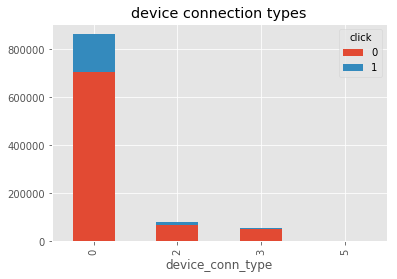

In [45]:
device_conn_temp = train_data[['device_conn_type','click']].groupby(['device_conn_type','click'])
device_conn_temp.size().unstack().plot(kind='bar',stacked=True, title='device connection types')

In [46]:
train_data[['device_conn_type','click']].groupby(['device_conn_type']).count().sort_values('click',ascending=False)

,click
device_conn_type,
0,863155
2,81504
3,54266
5,1076


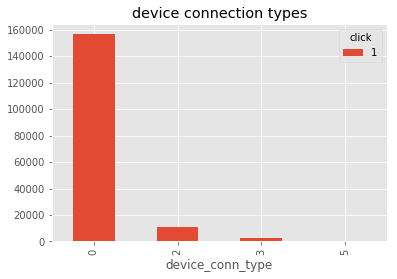

In [47]:
train_data_clicks[['device_conn_type','click']].groupby(['device_conn_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device connection types')

In [48]:
train_data_clicks[['device_conn_type','click']].groupby(['device_conn_type']).count().sort_values('click',ascending=False)

,click
device_conn_type,
0,156525
2,11078
3,2469
5,34


In [49]:
dev_conn_type_df_total_imp = train_data.groupby('device_conn_type').agg({'click':'count'})
dev_conn_type_df = train_data_clicks.groupby('device_conn_type').agg({'click':'count'})
dev_conn_type_df['total_impressions'] = dev_conn_type_df_total_imp['click']
dev_conn_type_df['click_pct'] = (dev_conn_type_df['click']/dev_conn_type_df['total_impressions'])*100
dev_conn_type_df

,click,total_impressions,click_pct
device_conn_type,,,
0,156525,863155,18.134055
2,11078,81504,13.591971
3,2469,54266,4.549810
5,34,1076,3.159851


## Device Type Metric Analysis

In [50]:
train_data['device_type'].unique()

array([1, 0, 4, 5], dtype=uint64)

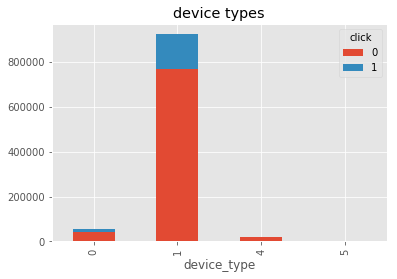

In [51]:
device_temp = train_data[['device_type','click']].groupby(['device_type','click'])
device_temp.size().unstack().plot(kind='bar',stacked=True, title='device types')

In [52]:
train_data[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,922458
0,54894
4,19482
5,3167


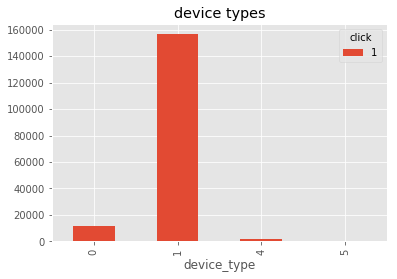

In [53]:
train_data_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [54]:
train_data_clicks[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,156509
0,11429
4,1869
5,299


### Device Type 1 gets the maximum number of impressions and clicks both

### Further Analysing clicks for device type 1

In [55]:
device1_df = train_data_clicks[train_data_clicks['device_type']==1]

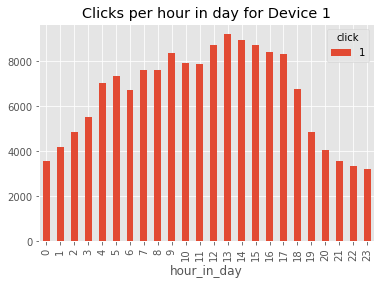

In [56]:
temp_device_df = device1_df.groupby(['hour_in_day', 'click'])
temp_device_df.size().unstack().plot(kind='bar', stacked=True, title="Clicks per hour in day for Device 1")

In [57]:
dev_type_df_total_imp = train_data.groupby('device_type').agg({'click':'count'})
dev_type_df = train_data_clicks.groupby('device_type').agg({'click':'count'})
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']
dev_type_df['click_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100
dev_type_df

,click,total_impressions,click_pct
device_type,,,
0,11429,54894,20.820126
1,156509,922458,16.966518
4,1869,19482,9.593471
5,299,3167,9.441111


### Device Type 0 with the highest click through rate

## App Related Metric Analysis
#### (App_Id, App_Domain, App_Category)

In [58]:
# df=pd.DataFrame()
# df['app_id']=train_data['app_id'].unique()
# df
train_data['app_id'].value_counts()

ecad2386    639351
92f5800b     38438
e2fcccd2     27784
febd1138     18768
9c13b419     18748
7358e05e     15127
a5184c22     12043
d36838b1     11230
685d1c4c     10027
54c5d545      9953
03528b27      7846
f0d41ff1      7289
e9739828      7057
e2a1ca37      6856
51cedd4e      5875
66f5e02e      5626
03a08c3f      5548
98fed791      5353
f53417e1      4983
73206397      4796
e96773f0      4387
ce183bbd      3633
be7c618d      2886
1dc72b4d      2653
f888bf4c      2591
396df801      2478
3c4b944d      2201
39947756      2135
cf0327f9      2124
3f2a6cbb      2041
             ...  
be641d2f         1
b6cdbeb8         1
b2d4c5d5         1
b517cba6         1
cf870a9a         1
d14986f2         1
0f760060         1
5e9d142e         1
8db0ce68         1
ee8335eb         1
25c8d208         1
49ce75e6         1
a2c6feb2         1
9bbde473         1
1ec61f38         1
d226ad3e         1
a80d9c42         1
5e677b98         1
f8ae6740         1
2eb52749         1
5a8ca1ae         1
83431aa8    

In [59]:
train_data['app_domain'].value_counts()

7801e8d9    674252
2347f47a    129368
ae637522     46480
5c5a694b     27790
82e27996     18768
d9b5648e     17709
0e8616ad     16311
b9528b13     15865
b8d325c3     13070
aefc06bd      7406
df32afa9      7207
33da2e74      6424
6f7ca2ba      5627
5b9c592b      2591
885c7f3f      1679
5c620f04      1508
45a51db4      1424
b5f3b24a      1199
813f3323       604
0654b444       565
ad63ec9b       459
c6824def       354
15ec7f39       329
a8b0bf20       316
99b4c806       244
828da833       230
43cf4f06       174
f2f777fb       172
448ca2e3       141
47464e95       112
             ...  
a5ab1a9f         1
5bcedd7d         1
4e0bb613         1
3df323d8         1
a5f9dc5b         1
5ce5b882         1
fe369646         1
214e1541         1
435769ed         1
5c8af8e9         1
89896125         1
13ed06ee         1
063914ab         1
55240cf0         1
1833416a         1
519a450d         1
788e5855         1
af237497         1
bb85b34d         1
1c895c8c         1
fd68cbd8         1
999f1fac    

In [60]:
train_data['app_category'].value_counts()

07d7df22    647584
0f2161f8    236572
cef3e649     42708
8ded1f7a     35772
f95efa07     28334
d1327cf5      3099
09481d60      1388
dc97ec06      1360
75d80bbe       986
fc6fa53d       588
4ce2e9fc       496
879c24eb       322
a3c42688       304
0f9a328c       140
4681bb9d       135
a86a3e89        63
2281a340        53
8df2e842        43
79f0b860        14
0bfbc358        13
7113d72a         7
18b1e0be         6
a7fd01ec         6
5326cf99         4
2fc4f2aa         2
86c1a5a3         1
4b7ade46         1
Name: app_category, dtype: int64

In [61]:
train_data.groupby('app_category').agg({'click':'count'}).sort_values(by='click',ascending = False)

,click
app_category,
07d7df22,647584
0f2161f8,236572
cef3e649,42708
8ded1f7a,35772
f95efa07,28334
d1327cf5,3099
09481d60,1388
dc97ec06,1360
75d80bbe,986


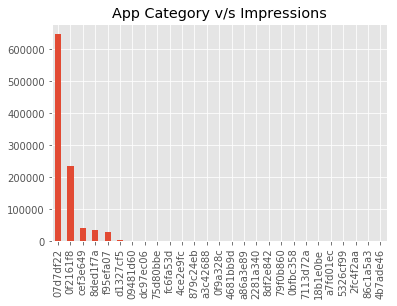

In [62]:
train_data['app_category'].value_counts().plot(kind='bar', title='App Category v/s Impressions')

In [63]:
train_data_clicks.groupby('app_category').agg({'click':'count'}).sort_values(by='click',ascending = False)

,click
app_category,
07d7df22,129178
0f2161f8,25598
f95efa07,6976
cef3e649,4062
8ded1f7a,3218
d1327cf5,358
09481d60,207
dc97ec06,206
75d80bbe,111


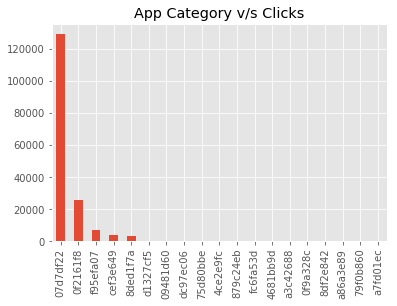

In [64]:
train_data_clicks['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')

In [65]:
app_cat_df_total_imp = train_data.groupby('app_category').agg({'click':'count'})
app_cat_df = train_data_clicks.groupby('app_category').agg({'click':'count'})
app_cat_df['total_impressions'] = app_cat_df_total_imp['click']
app_cat_df['click_pct'] = (app_cat_df['click']/app_cat_df['total_impressions'])*100
app_cat_df.sort_values('click_pct',ascending=False)

,click,total_impressions,click_pct
app_category,,,
8df2e842,12,43,27.906977
f95efa07,6976,28334,24.620597
07d7df22,129178,647584,19.947682
a7fd01ec,1,6,16.666667
4681bb9d,22,135,16.296296
dc97ec06,206,1360,15.147059
09481d60,207,1388,14.913545
0f9a328c,18,140,12.857143
4ce2e9fc,59,496,11.895161


## Site Related Metric Analysis
### (site_id, site_domain, site_category )

In [66]:
train_data['site_id'].value_counts()

85f751fd    360650
1fbe01fe    160115
e151e245     65441
d9750ee7     23878
5b08c53b     22527
5b4d2eda     19132
856e6d3f     18840
a7853007     11347
b7e9786d      9183
5ee41ff2      8662
6399eda6      8361
5bcf81a2      8351
6256f5b4      7905
57ef2c87      7690
17caea14      6957
0a742914      6639
57fe1b20      6587
83a0ad1a      6583
e8f79e60      6444
e4d8dd7b      6367
d6137915      5758
12fb4121      4749
6c5b482c      4724
93eaba74      4555
e5c60a05      4510
9a977531      4254
bb4524e7      4149
5114c672      4105
e3c09f3a      4042
4bf5bbe2      3787
             ...  
0c6d089f         1
36717516         1
8ad7a49f         1
3a853d01         1
ab24733e         1
a158f0e3         1
134ccc87         1
db8bb53b         1
fa293e12         1
5252191f         1
a0980ec7         1
321c8afb         1
26065e89         1
f86ed51c         1
ee485e3f         1
463a95dc         1
4acceee1         1
0b4f552f         1
6eb6ebcf         1
57deebc4         1
2b3f1160         1
bd5c7b9a    

In [67]:
train_data['site_domain'].value_counts()

c4e18dd6    373891
f3845767    160115
7e091613     82422
7687a86e     31806
98572c79     24702
16a36ef3     21246
58a89a43     18840
b12b9f85      9313
9d54950b      9211
17d996e6      8765
968765cd      8361
28f93029      7906
bd6d812f      7690
d262cf1e      7214
0dde25ec      6957
510bd839      6639
5b626596      6606
5c9ae867      6583
c4342784      6444
a17bde68      6367
6b59f079      5972
bb1ef334      5758
7256c623      5509
a434fa42      5013
d733bbc3      4149
3f2f3819      4105
6b560cc1      3787
c1aa3c04      3180
27e3c518      3162
e2a5dc06      2952
             ...  
282aca62         1
3fe68c23         1
43acdf2c         1
0e57dbf7         1
06ac5778         1
d5888200         1
a437194d         1
205d7510         1
51169db6         1
8af8855a         1
78f6d47e         1
4ce1e088         1
16e653cc         1
072c982b         1
01d53185         1
4e791211         1
1aefd708         1
8c5b3ac8         1
a570ed1a         1
55d1d202         1
538f4133         1
290f19a0    

In [68]:
train_data['site_category'].value_counts()

50e219e0    408577
f028772b    313532
28905ebd    182420
3e814130     75470
f66779e6      6237
75fa27f6      4052
335d28a8      3382
76b2941d      2600
c0dd3be3      1043
72722551       698
dedf689d       605
70fb0e29       585
0569f928       415
8fd0aea4       180
a818d37a        73
42a36e14        58
bcf865d9        28
e787de0e        25
5378d028        15
9ccfa2ea         6
Name: site_category, dtype: int64

In [69]:
train_data.groupby('site_category').agg({'click':'count'}).sort_values(by='click',ascending = False)

,click
site_category,
50e219e0,408577
f028772b,313532
28905ebd,182420
3e814130,75470
f66779e6,6237
75fa27f6,4052
335d28a8,3382
76b2941d,2600
c0dd3be3,1043


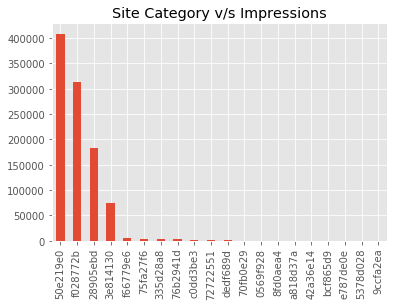

In [70]:
train_data['site_category'].value_counts().plot(kind='bar', title='Site Category v/s Impressions')

In [71]:
train_data_clicks.groupby('site_category').agg({'click':'count'}).sort_values(by='click',ascending = False)

,click
site_category,
f028772b,56365
50e219e0,52434
28905ebd,38067
3e814130,21485
75fa27f6,461
335d28a8,340
dedf689d,322
f66779e6,271
c0dd3be3,118


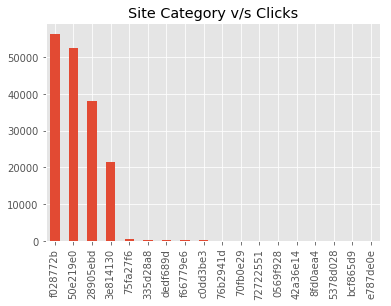

In [72]:
train_data_clicks['site_category'].value_counts().plot(kind='bar', title='Site Category v/s Clicks')

In [73]:
site_cat_df_total_imp = train_data.groupby('site_category').agg({'click':'count'})
site_cat_df = train_data_clicks.groupby('site_category').agg({'click':'count'})
site_cat_df['total_impressions'] = site_cat_df_total_imp['click']
site_cat_df['click_pct'] = (site_cat_df['click']/site_cat_df['total_impressions'])*100
site_cat_df.sort_values('click_pct',ascending=False)

,click,total_impressions,click_pct
site_category,,,
dedf689d,322,605,53.223140
3e814130,21485,75470,28.468266
42a36e14,16,58,27.586207
28905ebd,38067,182420,20.867778
5378d028,3,15,20.000000
f028772b,56365,313532,17.977431
70fb0e29,76,585,12.991453
50e219e0,52434,408577,12.833322
75fa27f6,461,4052,11.377098


## C1, C14-C21 features

In [74]:
features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

train_data[features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001
unique,7,2235,8,9,422,4,67,161,60
top,1005,4687,320,50,1722,0,35,65535,23
freq,918375,23418,932886,943382,111665,419063,300139,468157,220190


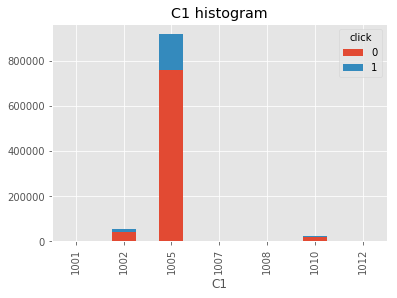

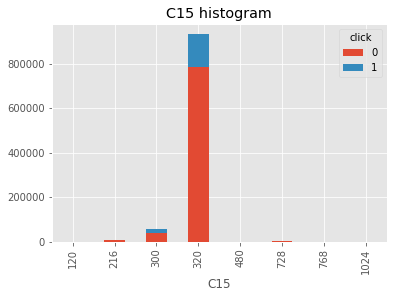

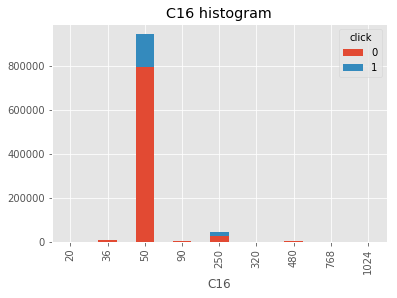

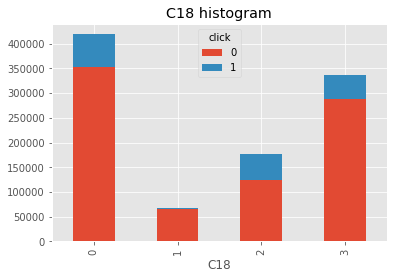

In [75]:
train_data.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train_data.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 histogram')
train_data.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 histogram')
train_data.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

# Model Selection

In [76]:
model_features = ['weekday', 'hour_in_day',
                  'banner_pos', 'site_category',
                  'device_conn_type', 'app_category',
                  'device_type']
model_target = 'click'
train_model = train_data[model_features+[model_target]].sample(frac=0.3,random_state=42)
# Clubbing the model features with the target and selecting a fraction in order to speeden up computation

In [77]:
train_model.info()
# train_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 624589 to 718206
Data columns (total 8 columns):
weekday             300000 non-null int64
hour_in_day         300000 non-null int64
banner_pos          300000 non-null uint16
site_category       300000 non-null object
device_conn_type    300000 non-null uint16
app_category        300000 non-null object
device_type         300000 non-null uint16
click               300000 non-null uint16
dtypes: int64(2), object(2), uint16(4)
memory usage: 13.7+ MB


In [78]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame
train_model = one_hot_features(train_model,
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])

In [79]:
train_model

,weekday,hour_in_day,device_conn_type,device_type,click,site_category_0569f928,site_category_28905ebd,site_category_335d28a8,site_category_3e814130,site_category_42a36e14,...,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7
624589,0,10,3,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
79954,1,16,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
567130,6,16,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
500891,6,2,3,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
55399,1,10,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
135049,2,7,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
693951,1,6,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
732058,1,12,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
51333,1,9,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
731480,1,12,3,4,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [80]:
model_features = np.array(train_model.columns[train_model.columns!=model_target].tolist())

In [81]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    train_model[model_features].values,
    train_model[model_target].values,
    test_size=0.25,
    random_state=42
)


In [82]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
'''Feature Selection ~ To reduce the dimensional space occupied and to deal with overfitting,
use GRID SEARCH cross validation and regularization to obtain trade off b/w number of features and F-1 score'''

'Feature Selection ~ To reduce the dimensional space occupied and to deal with overfitting,\nuse GRID SEARCH cross validation and regularization to obtain trade off b/w number of features and F-1 score'

In [83]:
num_splits = 3
c_values = np.logspace(-3,0,7)
stratified_k_fold = StratifiedKFold(n_splits=num_splits)

scores = np.zeros(7)
nr_params = np.zeros(7)

In [84]:
# Model: logistic Regression with L1 regularization and balanced class weights

for train_data, valid_data in stratified_k_fold.split(x_train,
                                                      y_train):
    for i, c in enumerate(np.logspace(-3, 0, 7)):
        lr_classify = LogisticRegression(penalty='l1',
                                         class_weight='balanced',
                                         C = c)
        lr_classify.fit(x_train[train_data],
                        y_train[train_data])

        #validation_Set evaluation

        y_prediction = lr_classify.predict(x_train[valid_data])
        score_f1 = f1_score(y_train[valid_data],
                            y_prediction, average='weighted' )

        scores[i] += score_f1 / num_splits

        ### spot the selected parameters ##

        model_selected = SelectFromModel(lr_classify, prefit=True)
        nr_params[i] += np.sum(model_selected.get_support()) / num_splits

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Krishna.Priya\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Us

Text(0, 0.5, 'Avg F1 score')

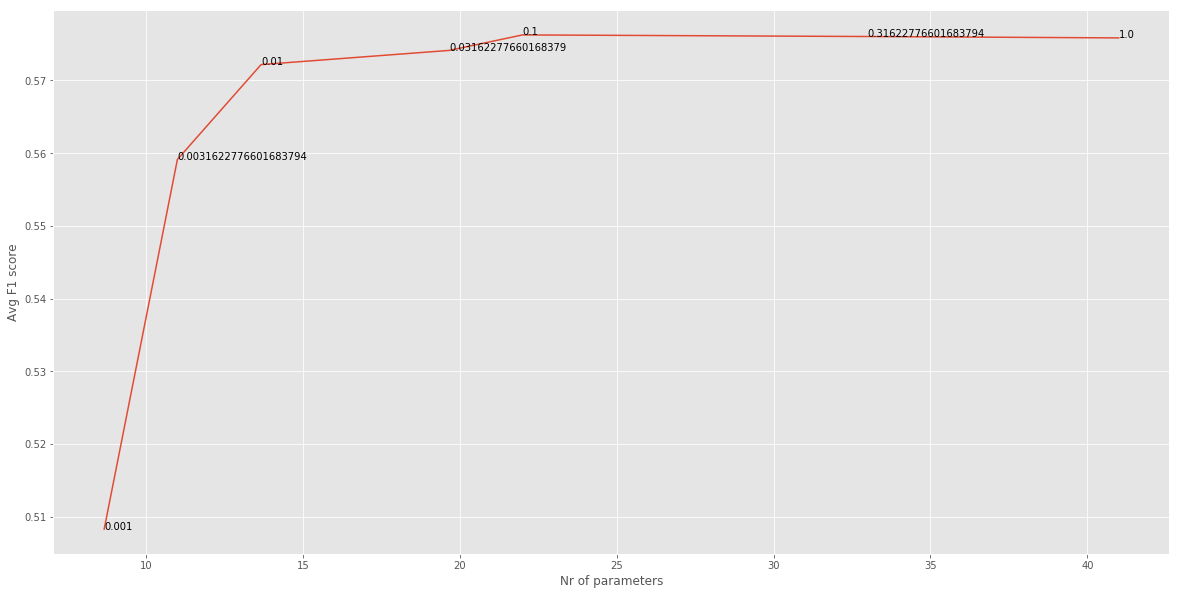

In [85]:
plt.figure(figsize=(20, 10))
plt.plot(nr_params, scores)

for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Nr of parameters")
plt.ylabel("Avg F1 score")

In [86]:
lr_classify = LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [87]:
lr_classify.fit(x_train, y_train)

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
model_selected = SelectFromModel(lr_classify,
                                 prefit=True )

In [89]:
pruned_params = model_selected.get_support()
pruned_params

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False, False,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True, False,  True, False, False,
        True,  True])

In [90]:
model_features = model_features[pruned_params]

x_train = x_train[:, pruned_params]

x_test = x_test[:, pruned_params]

In [91]:
# import pickle
# filename = 'Pickle_CTR_LR_model.sav'
# pickle.dump(lr_classify, open(filename, 'wb'))

In [92]:
# from sklearn.externals import joblib
# filename = 'Joblib_CTR_LR_model.sav'
# joblib.dump(lr_classify, filename)

In [93]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [94]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    stratify=y_train,
    test_size=0.1,
    random_state=42)

In [95]:
model = XGBClassifier()
xgb_clf = model

In [98]:
xgb_clf.fit(x_train, y_train, early_stopping_rounds=10,
            eval_metric="logloss", eval_set=[(x_valid, y_valid)])

[0]	validation_0-logloss:0.65037
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.615535
[2]	validation_0-logloss:0.586878
[3]	validation_0-logloss:0.563173
[4]	validation_0-logloss:0.543461
[5]	validation_0-logloss:0.526987
[6]	validation_0-logloss:0.513218
[7]	validation_0-logloss:0.501675
[8]	validation_0-logloss:0.491945
[9]	validation_0-logloss:0.483808
[10]	validation_0-logloss:0.476962
[11]	validation_0-logloss:0.471192
[12]	validation_0-logloss:0.466353
[13]	validation_0-logloss:0.462049
[14]	validation_0-logloss:0.458625
[15]	validation_0-logloss:0.455771
[16]	validation_0-logloss:0.453137
[17]	validation_0-logloss:0.451133
[18]	validation_0-logloss:0.449437
[19]	validation_0-logloss:0.447987
[20]	validation_0-logloss:0.446775
[21]	validation_0-logloss:0.445748
[22]	validation_0-logloss:0.444891
[23]	validation_0-logloss:0.444167
[24]	validation_0-logloss:0.443549
[25]	validation_0-logloss:0.443043
[26]	validation_0-logloss:0.44260

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [99]:
y_pred = xgb_clf.predict(x_test)
predictions = [round(value) for value in y_pred]

In [100]:
print(classification_report(y_test,
                            predictions))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     62246
           1       0.76      0.00      0.00     12754

   micro avg       0.83      0.83      0.83     75000
   macro avg       0.80      0.50      0.46     75000
weighted avg       0.82      0.83      0.75     75000



In [101]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, predictions))
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.roc_auc_score(y_test, predictions))


0.8302133333333334
[[62237     9]
 [12725    29]]
0.5010646044259955


# The model has an 83% accuracy score

In [102]:
import pickle
filename = 'xgb_mod.sav'
filename2 = 'logistic.sav'
pickle.dump(xgb_clf,open(filename, 'wb' ))
pickle.dump(lr_classify, open(filename2, 'wb'))